# Imports

In [133]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets
# !pip install -U gensim

In [134]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import warnings
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel
from collections import Counter
from gensim.models import Word2Vec

# Loading Data

In [135]:
df = pd.read_csv('pre-processed data.csv').set_index(['article_id' , 'paragraph_id'], inplace=False)
df['pos_tags'] = df['pos_tags'].apply(ast.literal_eval)
df

text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaran stikstofvergunni...   
           3             hoog drempelwaard vergunning [NEWLINE] aangevo...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergren lang onderwerp discussie huidig Nede...   
...                                                                    ...   
118        2             telgenkamp vestigen hoop kort termijn twee cru...   
119        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
120        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachten patiënt snel zorg helpen [...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group publication_date  \
article_id paragraph_id                                     
1          1             Bouw & Vastgoed       2024-08-28   
           2             Bouw & Vastgoed       2024-08-28   
           3             Bouw & Vastgoed       2024-08-28   
           4             Bouw & Vastgoed       2024-08-28   
           5             Bouw & Vastgoed       2024-08-28   
...                                  ...              ...   
118        2                        Zorg       2024-10-08   
119        1                        Zorg       2024-10-17   
120        1                        Zorg       2024-10-16   
           2                        Zorg       2024-10-16   
           3                        Zorg       2024-10-16   

                                                      file_path  \
article_id paragraph_id                                           
1          1             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           2             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           3             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           4             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           5             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
...                                                         ...   
118        2                        data\Zorg\7, 08-10-2024.pdf   
119        1                        data\Zorg\8, 17-10-2024.pdf   
120        1                        data\Zorg\9, 16-10-2024.pdf   
           2                        data\Zorg\9, 16-10-2024.pdf   
           3                        data\Zorg\9, 16-10-2024.pdf   

                                                             original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             provincies willen slag versoepeling stikstofre...   
           2             draait allemaal drempelwaarde stikstofvergunni...   
           3             hogere drempelwaarde vergunningen [NE

In [136]:
for group in df['group'].unique():
    print(f"{len(df[df['group'] == group])} paragraphs in {group}.")

124 paragraphs in Bouw & Vastgoed.
114 paragraphs in Handel & Industrie.
83 paragraphs in Zakelijke Dienstverlening.
53 paragraphs in Zorg.


# Overarching Function

**The function evaluate_model() as described below is an overarching function for finding the model with the highest validation accuracy given the provided parameter values.** <br>

Expected parameter values: <br>
- **df**: Pandas DataFrame containing the following columns:
> **original_text**: Text before any pre-processing steps were taken, $str$ <br>
> **text before lemmatization**: Text just before lemmatization has taken place, $str$ <br>
> **text**: Text after all pre-processing steps have been completed, $str$ <br>
> **pos_tags**: Part-Of-Speech tags, $list$ <br>
> **group**: Target variable, $str$ (Converted to numeric in the evaluate_model function) <br>
- **test_ratio**: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> Note that in the case of hold-out cross-validation (which is performed when $k=1$), test_ratio is also used the ratio of training data that is reserved for validation.
- **k_values**: List of k values for k-fold cross-validation. Default value: [2, 3, 5, 10, 20]
- **model_type**: Selects the type of classifier from amongst the following: ["svm", "naive_bayes", "random_forest"].
> If model_type="naive_bayes", a multinomial naive bayes classifier is trained if $pos=$"none" and embedding $\in$ ["BoW", "tf-idf"]. Otherwise, a Gaussian naive bayes classifier is trained since the resulting word embedding will contain continuous features, which multinomial naive bayes classifiers cannot handle.
- **embedding**: Selects the type of word embedding from amongst the following: ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"].
- **pos**: Selects how POS tags are used from amongst the following: ["none", "one-hot", "ngram"].
- **ngram_size**: Selects the type of ngrams that are used. Must be an integer, no smaller than 2. Set to 2 by default.
> Note that if _pos_$\neq$"ngram", n is not used and the value of ngram_size is irrelevant.
- **print_updates**: If set to True, intermediate and final results will be printed in addition to being returned. Default value: True
- **show_class_accuracy**: If set to True, the accuracies per class are shown for the final classifier. Default: True
- **show_confusion_matrix**: If set to True, the resulting confusion matrix of the final classifier will be shown. Default: True
- **return_data**: If set to True, the function returns not only results and best_model, but also the data used to train, validate and test the model

**The parameters below are model-specific and their values are only relevant if the corresponding model type is selected.**

- **C_values**: A list containing all values of C to be tested for SVM classifiers. Default value: [0.1, 1, 10]
- **kernel_values**: A list containing all kernel types to be tested for SVM classifiers. Default value: ['linear', 'rbf', 'poly']
- **max_depth_values**: A list containing all maximum depth values to be tested for Random Forest classifiers. Default value: [5, 10, 15, 20, None]
- **alpha_values**: A list containing all $\alpha$ values to be tested for multinomial naive bayes classifiers. Default value: [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
- **fit_prior_values**: A list containing all prior_values values to be tested for Multinomial Naive Bayes classifiers. Default value: [True, False]
- **var_smoothing_values**: A list containing all var_smoothing values to be tested for Gaussian Naive Bayes classifiers. Default value: [$10^{-11}$, $10^{-10}$, $10^{-9}$, $10^{-8}$, $10^{-7}$]

In [137]:
def evaluate_model(df: pd.DataFrame, test_ratio: float = 0.15, k_values: list = [2, 3, 5, 10, 20], 
                   model_type: str = "svm", embedding: str = "tf-idf",
                   pos: str = "none", ngram_size: int = 2, print_updates: bool = True,
                   show_class_accuracy: bool = True, show_confusion_matrix: bool = True, return_data = False,
                   C_values: list = [0.1, 1, 10], kernel_values: list = ['linear', 'rbf', 'poly'],
                   max_depth_values: list = [5, 10, 15, 20, None],
                   alpha_values: list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values: list = [True, False],
                   var_smoothing_values: list = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7]):
    """
    Function to extract embeddings (TF-IDF or BERTje), perform classification with SVM hyperparameter tuning, and evaluate using k-fold cross-validation.

    For parameters, see the markdown above this cell.

    Returns:
        dict: Dictionary of accuracies for each k and best SVM hyperparameters.
    """
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError(f"Invalid test_ratio. Choose a value in the exclusive interval (0,1)")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if model_type.lower() not in ["svm", "naive_bayes", "random_forest"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'Naive_Bayes', 'Random_Forest'}")
    if embedding.lower() not in ["bow", "tf-idf", "bertje", "mbert", "robbert", "word2vec"]:
        raise ValueError(f'Invalid embedding. Choose from ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]')
    if pos not in ["none", "one-hot", "ngram"]:
        raise ValueError(f'Invalid pos. Choose from ["none", "one-hot", "ngram"]')
    if type(ngram_size) != int or ngram_size < 2:
        raise ValueError(f'Invalid ngram_size. Please ensure that ngram_size is an integer, no smaller than 2')
    if not type(print_updates) == bool:
        raise ValueError(f'Invalid print_updates value. Please ensure this parameter has a boolean value.')
    if not all(x > 0 for x in C_values):
        raise ValueError(f'Invalid C_values. Please ensure that all entries in C_values lie in the exclusive interval (0, inf)')
    if not all(type(x) == str for x in kernel_values):
        raise ValueError(f'Invalid kernel_values. Please ensure every entry in kernel_values is a string that represents a kernel type')
    if not all((type(x) == int and x > 0) or x == None for x in max_depth_values):
        raise ValueError(f'Invalid max_depth_values. Please ensure every entry in max_depth_values is a positive integer or None for no maximum')
    if not all((type(x) == int or type(x) == float) and (x > 0) for x in alpha_values):
        raise ValueError(f'Invalid alpha_values. Please ensure every entry in alpha_values is numeric and non-negative')
    if not all(type(x) == bool for x in fit_prior_values):
        raise ValueError(f'Invalid fit_prior_values. Please ensure every entry in fit_prior_values is boolean')
    if not all(x >= 0 for x in var_smoothing_values):
        raise ValueError(f'Invalid var_smoothing_values. Please ensure every entry in var_smoothing_values is a non-negative number')
        

    # Convert labels to numeric format
    df["label"] = df["group"].astype("category").cat.codes 
    df_train, df_test = train_test_split(df, test_size=test_ratio, stratify=df["label"], random_state=42)
    
    # ===========================
    # 1. Extract Features (BoW, TF-IDF, BERTje, mBERT, RobBERT or Word2Vec)
    # ===========================

    if embedding.lower() == "bow":
        if print_updates:
            print("\nUsing Bag of Words (BoW) Embeddings...")
        vectorizer = CountVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])#.toarray()
    
    elif embedding.lower() == "tf-idf":
        if print_updates:
            print("\nUsing TF-IDF Embeddings...")
        vectorizer = TfidfVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])

    elif embedding.lower() in ["bertje", "mbert", "robbert"]:
        if embedding.lower() == "bertje":
            model_name = "GroNLP/bert-base-dutch-cased"
        elif embedding.lower() == "mbert":
            model_name = "bert-base-multilingual-cased"
        elif embedding.lower() == "robbert":
            model_name = "pdelobelle/robbert-v2-dutch-base"

        if print_updates:
            print(f"\nUsing {embedding.upper()} Embeddings ({model_name})...")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()

        def get_word_embedding(text):
            with torch.no_grad():
                tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
                output = model(**tokens)
                embeddings = output.last_hidden_state.mean(dim=1)
            return embeddings.squeeze().numpy()

        if print_updates:
            print(f"\nCreating {embedding} embedding, this may take a few minutes.")
        embeddings = np.array([get_word_embedding(text) for text in df_train["text"]])
        test_embeddings = np.array([get_word_embedding(text) for text in df_test["text"]])

    elif embedding.lower() == "word2vec":
        if print_updates:
            print("\nUsing Word2Vec Embeddings...")

        sentences = [text.split() for text in df_train["text"]]
        w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

        def get_w2v_embedding(text):
            words = text.split()
            word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

        embeddings = np.array([get_w2v_embedding(text) for text in df_train["text"]])
        test_embeddings = np.array([get_w2v_embedding(text) for text in df_test["text"]])

    else:
        raise ValueError("Invalid embedding type. Choose 'tf-idf' 'BERTje', 'mBERT', 'RobBERT' or 'Word2Vec'.")

    # ===========================
    # 2. Process POS Tags if Needed
    # ===========================

    if pos == "one-hot":
        if print_updates:
            print("\nUsing One-Hot Encoding for POS Tags...")

        def pos_to_features(pos_tags):
            """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
            pos_counts = Counter(tag for _, tag in pos_tags)
            return dict(pos_counts)

        # Convert to list of dictionaries
        pos_features = [pos_to_features(tags) for tags in df_train["pos_tags"]]
        test_pos_features = [pos_to_features(tags) for tags in df_test["pos_tags"]]
    
        # Convert list of dictionaries to Pandas DataFrame (fill missing tags with 0)
        pos_df = pd.DataFrame(pos_features).fillna(0)
        pos_df_test = pd.DataFrame(test_pos_features).fillna(0)

        # Ensure that pos_df_test and pos_df_test have the same columns
        pos_df_test = pos_df_test.reindex(columns=pos_df.columns, fill_value=0)
    
        # Create OneHotEncoder and use it on the pos features
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        pos_features_encoded = encoder.fit_transform(pos_df)
        pos_features_encoded_test = encoder.transform(pos_df_test)
    
        # Scale the POS features
        scaler = StandardScaler()
        pos_features_scaled = scaler.fit_transform(pos_features_encoded)
        pos_features_scaled_test = scaler.transform(pos_features_encoded_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_features_scaled, csr_matrix):  
            pos_features_scaled = csr_matrix(pos_features_scaled)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_test, csr_matrix):  
            pos_features_scaled_test = csr_matrix(pos_features_scaled_test)  # Convert dense to sparse

        # Combine embeddings with POS features
        embeddings = hstack([embeddings, pos_features_scaled])
        test_embeddings = hstack([test_embeddings, pos_features_scaled_test])

    elif pos.lower() == "ngram":
        if print_updates:
            print(f"\nUsing N-gram POS Features (n={ngram_size})...")
        
        # Function to convert POS tags to n-grams
        def pos_to_ngrams(pos_tags, n=2):
            """Convert a list of POS-tag tuples into n-gram strings."""
            pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
            ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
            return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

        # Create POS n-grams
        pos_ngrams = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_train["pos_tags"]])
        pos_ngrams_test = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_test["pos_tags"]])

        # Use TF-IDF to extract n-gram features
        vectorizer = TfidfVectorizer(max_features=1000)  # Use fewer features since it's for POS
        pos_embeddings = vectorizer.fit_transform(pos_ngrams)#.toarray()
        pos_embeddings_test = vectorizer.transform(pos_ngrams_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_embeddings, csr_matrix):  
            pos_embeddings = csr_matrix(pos_embeddings)  # Convert dense to sparse
        if not isinstance(pos_embeddings_test, csr_matrix):  
            pos_embeddings_test = csr_matrix(pos_embeddings_test)  # Convert dense to sparse
        
        # Combine embeddings with POS n-grams features
        embeddings = hstack([embeddings, pos_embeddings])
        test_embeddings = hstack([test_embeddings, pos_embeddings_test])

    elif pos != "none":
        raise ValueError("Invalid POS type. Choose 'none', 'one-hot', or 'ngram'.")

    # ===========================
    # 3. Model Evaluation (Holdout or k-Fold) with Hyperparameter Search
    # ===========================

    # Set initial performance metrics such that they can be updated after a better classifier has been found
    # best_k = None
    best_accuracy = 0
    best_params = None
    results = {}
    best_functionwide_accuracy = 0
    best_functionwide_params = None

    # For every value of k, we find the best parameter settings and save them in the results dictionary
    for k in k_values:
        param_results = {}
        # accuracy_scores = []
        # best_model_params = {}

        if k == 1: # Use regular hold-out cross-validation
            X_train, X_val, y_train, y_val = train_test_split(
                embeddings, df_train["label"], test_size=test_ratio, stratify=df_train["label"], random_state=42
            )
            
            if model_type.lower() == "svm":
                for C in C_values:
                    for kernel in kernel_values:
                        classifier = SVC(kernel=kernel, C=C)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((C, kernel), []).append(accuracy)
            
            elif model_type.lower() == "random_forest":
                for max_depth in max_depth_values:
                    classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                    classifier.fit(X_train, y_train)
                    accuracy = accuracy_score(y_val, classifier.predict(X_val))
                    param_results.setdefault((max_depth), []).append(accuracy)
            
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]: # In this case all features are discrete, so we can use MultinomialNB
                    for alpha in alpha_values:
                        for fit_prior in fit_prior_values:
                            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                else: # In this case, there are continuous features, so we use GaussianNB
                    for var_smoothing in var_smoothing_values:
                        classifier = GaussianNB(var_smoothing=var_smoothing)
                        
                        if isinstance(X_train, np.ndarray):
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        else:
                            classifier.fit(X_train.toarray(), y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            
                        param_results.setdefault((var_smoothing), []).append(accuracy)

            else:
                raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')

            # accuracy_scores.append(best_accuracy)
            
        else:  # Use stratified k-fold cross-validation
            kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
            for train_index, val_index in kf.split(embeddings, df_train["label"]):
                X_train, X_val = embeddings[train_index], embeddings[val_index]
                y_train, y_val = df_train["label"].iloc[train_index].values, df_train["label"].iloc[val_index].values
                
                best_fold_accuracy = 0
                
                if model_type == "svm":
                    for C in C_values:
                        for kernel in kernel_values:
                            classifier = SVC(kernel=kernel, C=C)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((C, kernel), []).append(accuracy)
                
                elif model_type == "random_forest":
                    for max_depth in max_depth_values:
                        classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((max_depth), []).append(accuracy)
                
                elif model_type == "naive_bayes":
                    if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                        for alpha in alpha_values:
                            for fit_prior in fit_prior_values:
                                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                                param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                    else:
                        for var_smoothing in var_smoothing_values:
                            classifier = GaussianNB(var_smoothing=var_smoothing)
                            if isinstance(X_train, np.ndarray):
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            else:
                                classifier.fit(X_train.toarray(), y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            param_results.setdefault((var_smoothing), []).append(accuracy)
                                
                else:
                    raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')
                
                # accuracy_scores.append(best_fold_accuracy)
        
        # results[k] = {"accuracy": np.mean(accuracy_scores), "best_params": best_model_params}

        # Compute mean accuracy for each hyperparameter set
        mean_accuracies = {params: np.mean(acc_list) for params, acc_list in param_results.items()}
        best_params = max(mean_accuracies, key=mean_accuracies.get)
        best_accuracy = mean_accuracies[best_params]
        results[k] = {"accuracy": best_accuracy, "best_params": best_params}
        
        if print_updates:
            print(f"Best {model_type} Params for k={k}: {results[k]['best_params']}, Mean Validation Accuracy: {results[k]['accuracy']:.4f}")
        
        if print_updates:
            print(f"param_results: {param_results}")
            print(f"mean results: {mean_accuracies}")
            print(f"best validation accuracy for K={k}: {best_accuracy}")
            print(f"best functionwide validation accuracy: {best_functionwide_accuracy}\n")

        # Train final model on full training set if this is the best performance so far
        if best_accuracy > best_functionwide_accuracy:
            best_functionwide_accuracy = best_accuracy
            best_functionwide_params = best_params
            if not isinstance(best_params, tuple):
                best_params = (best_params,)
            if model_type.lower() == "svm":
                best_model = SVC(C=best_params[0], kernel=best_params[1])
            elif model_type.lower() == "random_forest":
                best_model = RandomForestClassifier(max_depth=best_params[0], random_state=42)
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                    best_model = MultinomialNB(alpha=best_params[0], fit_prior=best_params[1])
                else:
                    best_model = GaussianNB(var_smoothing=best_params[0])
                    
            if isinstance(X_train, np.ndarray):
                best_model.fit(X_train, y_train)
            else:
                best_model.fit(X_train.toarray(), y_train)
    
    # Evaluate best model on test set
    if not isinstance(test_embeddings, np.ndarray):
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings.toarray()))
    else:
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings))
        
    if print_updates:
        print(f"\nBest model found: \nModel={model_type}, \nParameter values: {best_params}, \nValidation Accuracy: {best_functionwide_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")

    if show_class_accuracy:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        class_mapping = {0: 'Bouw & Vastgoed', 1: 'Handel & Industrie', 2: 'Zakelijke Dienstverlening', 3: 'Zorg'}
        class_names = [class_mapping[i] for i in np.unique(y_test)]
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

    if return_data:
        y_test = df_test["label"]
        return results, best_model, [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    else:
        return results, best_model

# Testing:


Using TF-IDF Embeddings...
Best random_forest Params for k=2: 15, Mean Validation Accuracy: 0.4889
param_results: {5: [0.4528301886792453, 0.4430379746835443], 10: [0.49056603773584906, 0.4620253164556962], 15: [0.5157232704402516, 0.4620253164556962], 20: [0.4968553459119497, 0.47468354430379744], None: [0.4779874213836478, 0.4873417721518987]}
mean results: {5: 0.4479340816813948, 10: 0.47629567709577264, 15: 0.4888742934479739, 20: 0.48576944510787357, None: 0.4826645967677733}
best validation accuracy for K=2: 0.4888742934479739
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.5204
param_results: {5: [0.5188679245283019, 0.4528301886792453, 0.4095238095238095], 10: [0.5471698113207547, 0.5188679245283019, 0.49523809523809526], 15: [0.5754716981132075, 0.5094339622641509, 0.47619047619047616], 20: [0.5471698113207547, 0.5, 0.4857142857142857], None: [0.5377358490566038, 0.49056603773584906, 0.4857142857142857]}
mean result

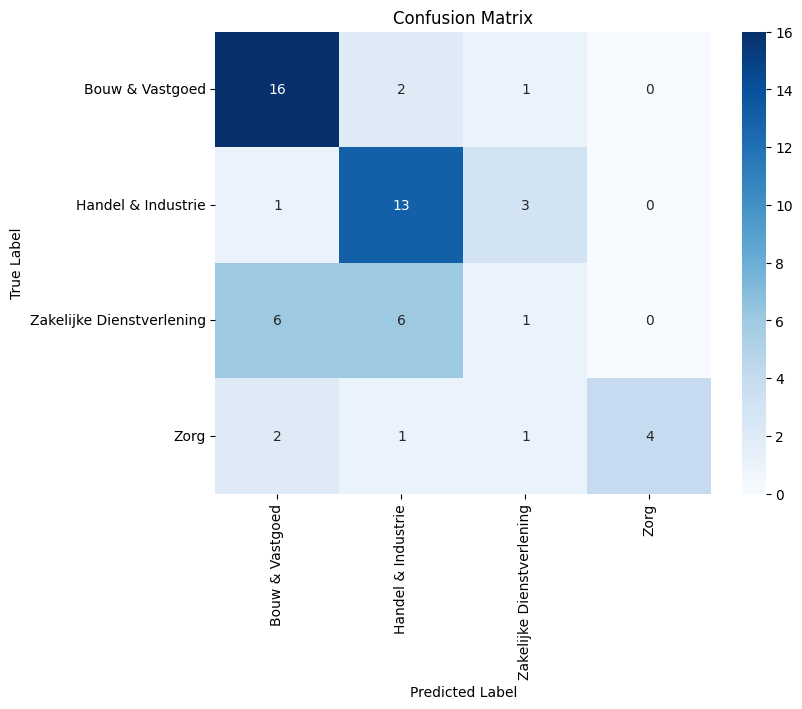

{2: {'accuracy': 0.4888742934479739, 'best_params': 15},
 3: {'accuracy': 0.5204252770290506, 'best_params': 10},
 5: {'accuracy': 0.5299107142857143, 'best_params': 20}}

In [44]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2,)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best random_forest Params for k=2: 5, Mean Validation Accuracy: 0.5647
param_results: {5: [0.5660377358490566, 0.5632911392405063], 10: [0.5849056603773585, 0.5253164556962026], 15: [0.5660377358490566, 0.5253164556962026], 20: [0.5660377358490566, 0.5253164556962026], None: [0.5660377358490566, 0.5253164556962026]}
mean results: {5: 0.5646644375447815, 10: 0.5551110580367805, 15: 0.5456770957726296, 20: 0.5456770957726296, None: 0.5456770957726296}
best validation accuracy for K=2: 0.5646644375447815
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.5897
param_results: {5: [0.5660377358490566, 0.5660377358490566, 0.47619047619047616], 10: [0.6320754716981132, 0.6226415094339622, 0.5142857142857142], 15: [0.6226415094339622, 0.6509433962264151, 0.49523809523809526], 20: [0.6226415094339622, 0.6509433962264151, 0.49523809523809526], None: [0.6226415094339622, 0.65094339622

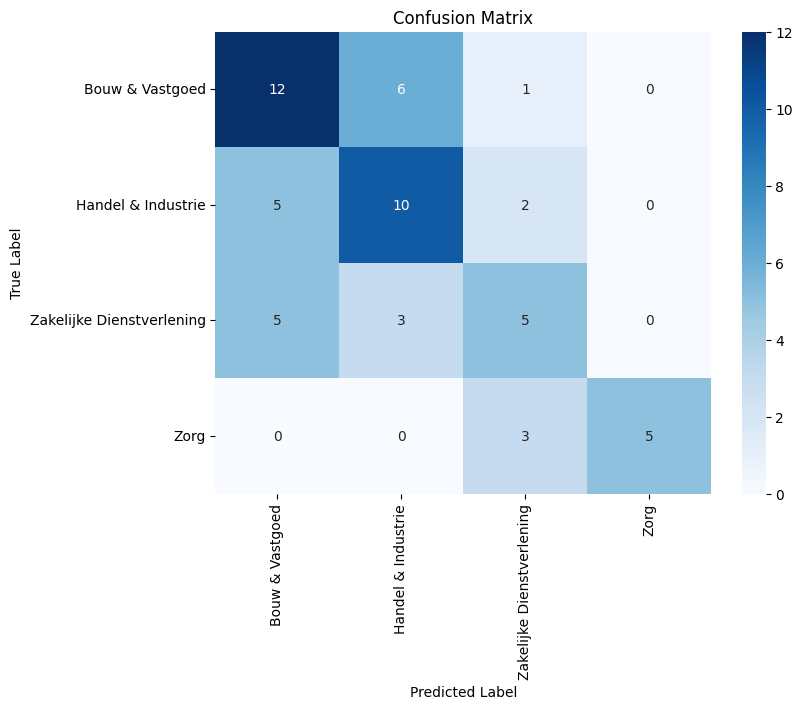

{2: {'accuracy': 0.5646644375447815, 'best_params': 5},
 3: {'accuracy': 0.5896675651392632, 'best_params': 10},
 5: {'accuracy': 0.5803075396825397, 'best_params': 10}}

In [45]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Using One-Hot Encoding for POS Tags...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best random_forest Params for k=2: 20, Mean Validation Accuracy: 0.4953
param_results: {5: [0.4276729559748428, 0.47468354430379744], 10: [0.4968553459119497, 0.45569620253164556], 15: [0.49056603773584906, 0.4810126582278481], 20: [0.49056603773584906, 0.5], None: [0.5031446540880503, 0.4873417721518987]}
mean results: {5: 0.4511782501393201, 10: 0.4762757742217976, 15: 0.4857893479818486, 20: 0.49528301886792453, None: 0.49524321311997455}
best validation accuracy for K=2: 0.49528301886792453
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 20, Mean Validation Accuracy: 0.5234
param_results: {5: [0.46226415094339623, 0.4811320754716981, 0.45714285714285713], 10: [0.5188679245283019, 0.4716981132075472, 0.4095238095238095], 15: [0.5471698113207547, 0.5471698113207547, 0.44761904761904764], 20: [0.5943396226415094, 0.5471698113207547, 0.42857142857142855], None: [0.5660377358490566, 0.5660377358490566, 0.4095238095238095]}
mean results: {5: 0.466846361185983

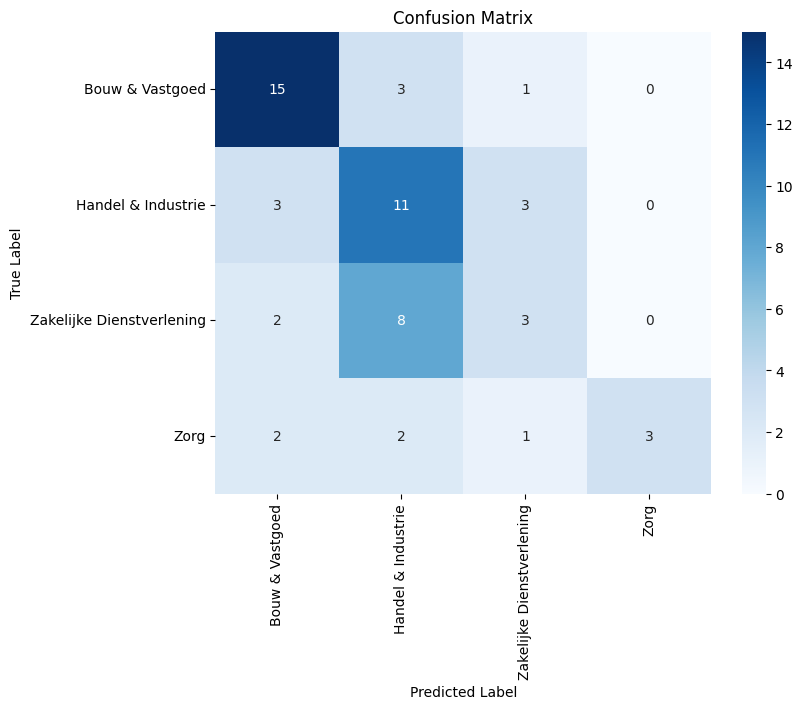

{2: {'accuracy': 0.49528301886792453, 'best_params': 20},
 3: {'accuracy': 0.5233602875112309, 'best_params': 20},
 5: {'accuracy': 0.5615575396825397, 'best_params': 20}}

In [46]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using MBERT Embeddings (bert-base-multilingual-cased)...

Creating mbert embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best random_forest Params for k=2: 15, Mean Validation Accuracy: 0.5298
param_results: {5: [0.5534591194968553, 0.4240506329113924], 10: [0.559748427672956, 0.46835443037974683], 15: [0.5849056603773585, 0.47468354430379744], 20: [0.5849056603773585, 0.47468354430379744], None: [0.5849056603773585, 0.47468354430379744]}
mean results: {5: 0.48875487620412383, 10: 0.5140514290263514, 15: 0.529794602340578, 20: 0.529794602340578, None: 0.529794602340578}
best validation accuracy for K=2: 0.529794602340578
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 15, Mean Validation Accuracy: 0.5677
param_results: {5: [0.6037735849056604, 0.5, 0.4666666666666667], 10: [0.6037735849056604, 0.5377358490566038, 0.49523809523809526], 15: [0.6132075471698113, 0.5660377358490566, 0.5238095238095238], 20: [0.6132075471698113, 0.55

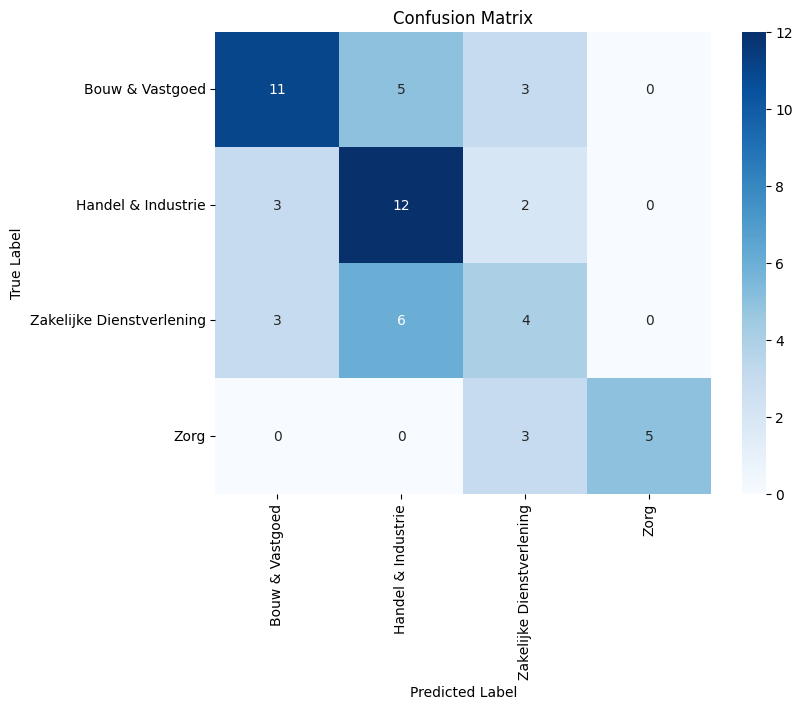

{2: {'accuracy': 0.529794602340578, 'best_params': 15},
 3: {'accuracy': 0.5676849356094639, 'best_params': 15},
 5: {'accuracy': 0.5546626984126984, 'best_params': 20}}

In [47]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "mbert", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best svm Params for k=2: (0.1, 'linear'), Mean Validation Accuracy: 0.6750
param_results: {(0.1, 'linear'): [0.7044025157232704, 0.6455696202531646], (0.1, 'rbf'): [0.3270440251572327, 0.34177215189873417], (0.1, 'poly'): [0.49056603773584906, 0.47468354430379744], (1, 'linear'): [0.6855345911949685, 0.6012658227848101], (1, 'rbf'): [0.5220125786163522, 0.4873417721518987], (1, 'poly'): [0.5471698113207547, 0.5126582278481012], (10, 'linear'): [0.6855345911949685, 0.6012658227848101], (10, 'rbf'): [0.7044025157232704, 0.6329113924050633], (10, 'poly'): [0.6855345911949685, 0.6455696202531646]}
mean results: {(0.1, 'linear'): 0.6749860679882175, (0.1, 'rbf'): 0.3344080885279834, (0.1, 'poly'): 0.48262479101982325, (1, 'linear'): 0.6434002069898893, (1, 'rbf'): 0.5046771753841255, (1, 'poly'): 0.529914019584428, (10, 'linear'): 0.6434002069898893, (10, 'rbf'): 0.6686569540641669, (10, 'poly'): 0.6655521057240665}
best validation ac

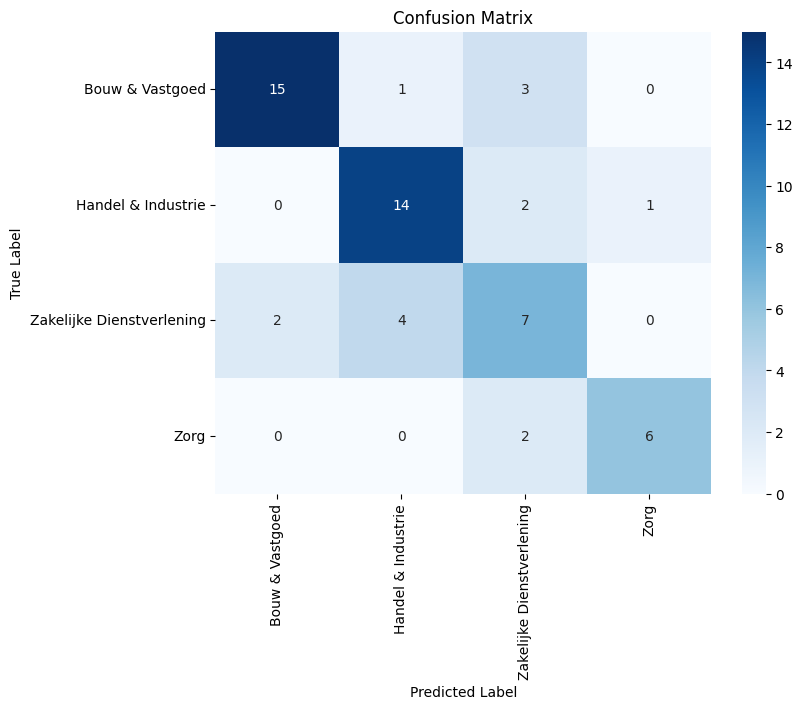

{2: {'accuracy': 0.6749860679882175, 'best_params': (0.1, 'linear')},
 3: {'accuracy': 0.7094938604372567, 'best_params': (10, 'rbf')},
 5: {'accuracy': 0.6938492063492063, 'best_params': (10, 'rbf')}}

In [48]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using One-Hot Encoding for POS Tags...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best svm Params for k=2: (1, 'rbf'), Mean Validation Accuracy: 0.4952
param_results: {(0.1, 'linear'): [0.5408805031446541, 0.44936708860759494], (0.1, 'rbf'): [0.3270440251572327, 0.33544303797468356], (0.1, 'poly'): [0.3270440251572327, 0.37341772151898733], (1, 'linear'): [0.5408805031446541, 0.44936708860759494], (1, 'rbf'): [0.5094339622641509, 0.4810126582278481], (1, 'poly'): [0.4025157232704403, 0.4177215189873418], (10, 'linear'): [0.5408805031446541, 0.44936708860759494], (10, 'rbf'): [0.5031446540880503, 0.47468354430379744], (10, 'poly'): [0.4088050314465409, 0.46835443037974683]}
mean results: {(0.1, 'linear'): 0.49512379587612454, (0.1, 'rbf'): 0.3312435315659581, (0.1, 'poly'): 0.35023087333811, (1, 'linear'): 0.49512379587612454, (1, 'rbf'): 0.4952233102459995, (1, 'poly'): 0.410118621128891, (10, 'linear'): 0.49512379587612454, (10, 'rbf'): 0.4889140991959239, (10, 'poly'): 0.43857973091314384}
best validation accuracy for K=2: 0.4952233102459995
best functionwide vali

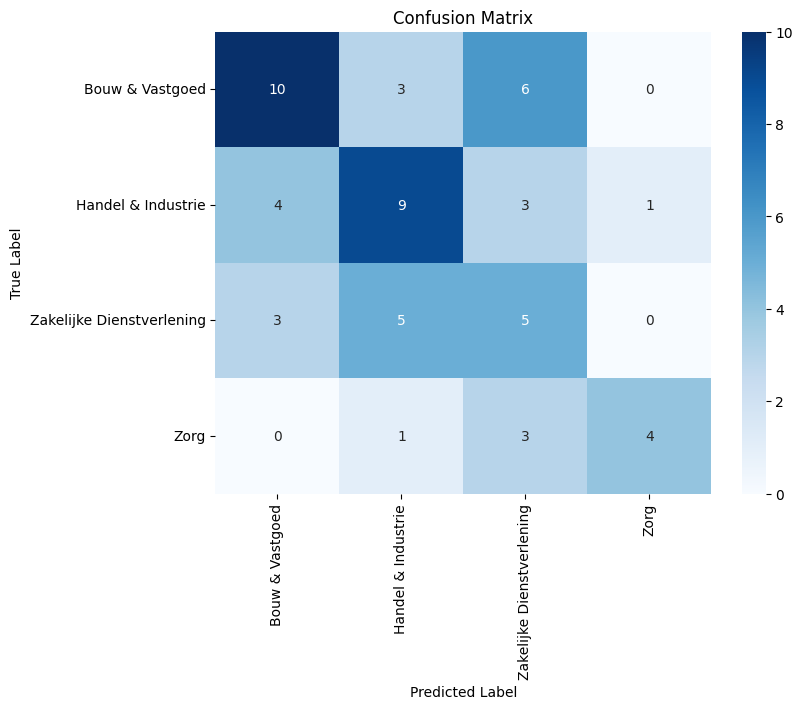

{2: {'accuracy': 0.4952233102459995, 'best_params': (1, 'rbf')},
 3: {'accuracy': 0.5076669661575323, 'best_params': (0.1, 'linear')},
 5: {'accuracy': 0.520188492063492, 'best_params': (0.1, 'linear')}}

In [49]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating robBERT embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best svm Params for k=2: (1, 'linear'), Mean Validation Accuracy: 0.6182
param_results: {(0.1, 'linear'): [0.6415094339622641, 0.5822784810126582], (0.1, 'rbf'): [0.3270440251572327, 0.33544303797468356], (0.1, 'poly'): [0.39622641509433965, 0.43670886075949367], (1, 'linear'): [0.6415094339622641, 0.5949367088607594], (1, 'rbf'): [0.5031446540880503, 0.44936708860759494], (1, 'poly'): [0.5031446540880503, 0.4620253164556962], (10, 'linear'): [0.6037735849056604, 0.5822784810126582], (10, 'rbf'): [0.5974842767295597, 0.5632911392405063], (10, 'poly'): [0.6289308176100629, 0.5632911392405063]}
mean results: {(0.1, 'linear'): 0.6118939574874611, (0.1, 'rbf'): 0.3312435315659581, (0.1, 'poly'): 0.41646763792691666, (1, 'linear'): 0.6182230714115118, (1, 'rbf'): 0.47625587134782266, (1, 'poly'): 0.48258498527187327, (10, 'linear'): 0.5930260329591592, (10, 'rbf'): 0.580387707985033, (10, 'poly'): 

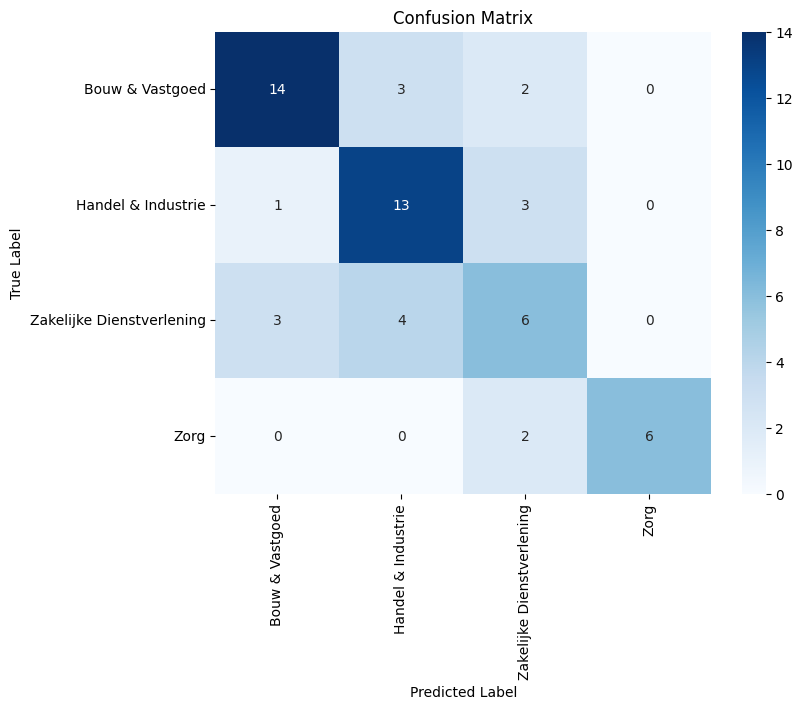

{2: {'accuracy': 0.6182230714115118, 'best_params': (1, 'linear')},
 3: {'accuracy': 0.6622042527702905, 'best_params': (0.1, 'linear')},
 5: {'accuracy': 0.7001488095238095, 'best_params': (10, 'poly')}}

In [50]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "robBERT", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.7160
param_results: {(0.01, True): [0.710691823899371, 0.7025316455696202], (0.01, False): [0.6729559748427673, 0.6265822784810127], (0.1, True): [0.7169811320754716, 0.6962025316455697], (0.1, False): [0.7295597484276729, 0.7025316455696202], (0.5, True): [0.559748427672956, 0.620253164556962], (0.5, False): [0.710691823899371, 0.6962025316455697], (1.0, True): [0.5283018867924528, 0.5379746835443038], (1.0, False): [0.6792452830188679, 0.6772151898734177], (2.0, True): [0.5031446540880503, 0.5443037974683544], (2.0, False): [0.6163522012578616, 0.6265822784810127], (5.0, True): [0.4591194968553459, 0.569620253164557], (5.0, False): [0.559748427672956, 0.5316455696202531], (10.0, True): [0.37735849056603776, 0.5569620253164557], (10.0, False): [0.5094339622641509, 0.47468354430379744]}
mean results: {(0.01, True): 0.7066117347344956, (0.01, False): 0.6497691266618899, (0.1, True): 0.

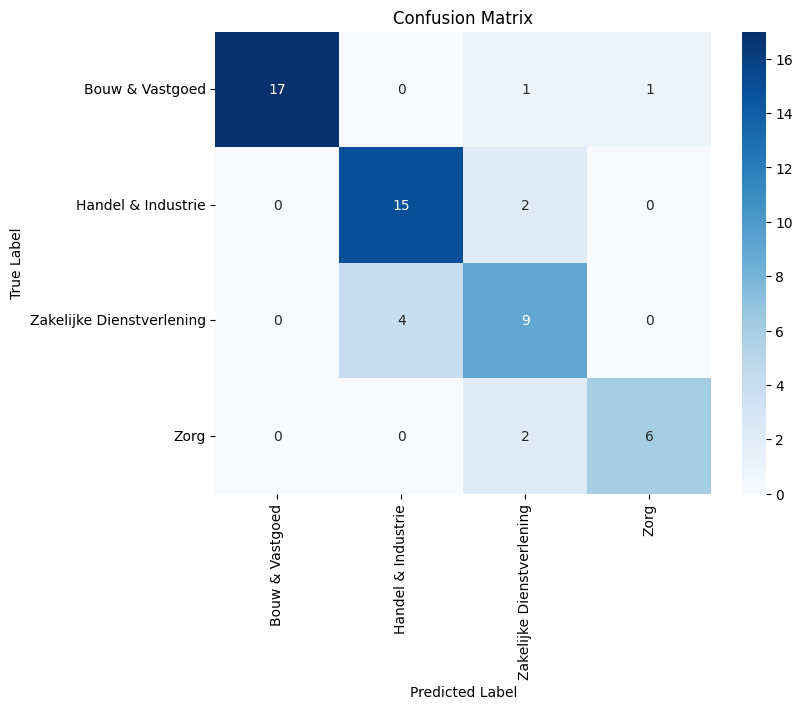

{2: {'accuracy': 0.7160456969986466, 'best_params': (0.1, False)},
 3: {'accuracy': 0.7317160826594789, 'best_params': (0.01, True)},
 5: {'accuracy': 0.7253968253968255, 'best_params': (0.01, True)}}

In [51]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.7160
param_results: {(0.01, True): [0.710691823899371, 0.7025316455696202], (0.01, False): [0.6729559748427673, 0.6265822784810127], (0.1, True): [0.7169811320754716, 0.6962025316455697], (0.1, False): [0.7295597484276729, 0.7025316455696202], (0.5, True): [0.559748427672956, 0.620253164556962], (0.5, False): [0.710691823899371, 0.6962025316455697], (1.0, True): [0.5283018867924528, 0.5379746835443038], (1.0, False): [0.6792452830188679, 0.6772151898734177], (2.0, True): [0.5031446540880503, 0.5443037974683544], (2.0, False): [0.6163522012578616, 0.6265822784810127], (5.0, True): [0.4591194968553459, 0.569620253164557], (5.0, False): [0.559748427672956, 0.5316455696202531], (10.0, True): [0.37735849056603776, 0.5569620253164557], (10.0, False): [0.5094339622641509, 0.47468354430379744]}
mean results: {(0.01, True): 0.7066117347344956, (0.01, False): 0.6497691266618899, (0.1, True): 0.

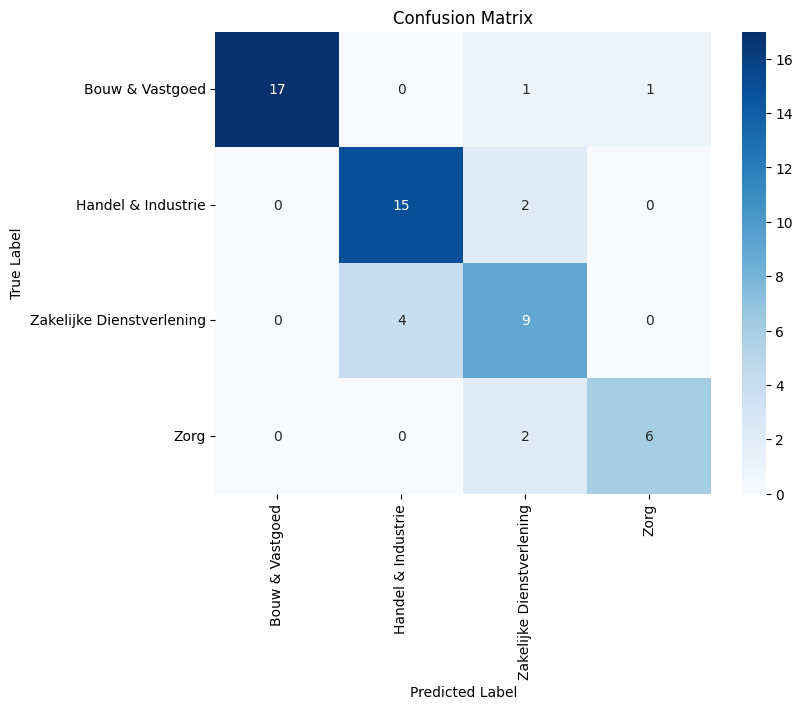

{2: {'accuracy': 0.7160456969986466, 'best_params': (0.1, False)},
 3: {'accuracy': 0.7317160826594789, 'best_params': (0.01, True)},
 5: {'accuracy': 0.7253968253968255, 'best_params': (0.01, True)}}

In [52]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using N-gram POS Features (n=2)...
Best naive_bayes Params for k=2: 1e-11, Mean Validation Accuracy: 0.6845
param_results: {1e-11: [0.710691823899371, 0.6582278481012658], 1e-10: [0.710691823899371, 0.6582278481012658], 1e-09: [0.710691823899371, 0.6582278481012658], 1e-08: [0.710691823899371, 0.6582278481012658], 1e-07: [0.710691823899371, 0.6582278481012658]}
mean results: {1e-11: 0.6844598360003185, 1e-10: 0.6844598360003185, 1e-09: 0.6844598360003185, 1e-08: 0.6844598360003185, 1e-07: 0.6844598360003185}
best validation accuracy for K=2: 0.6844598360003185
best functionwide validation accuracy: 0

Best naive_bayes Params for k=3: 1e-11, Mean Validation Accuracy: 0.6907
param_results: {1e-11: [0.7075471698113207, 0.7264150943396226, 0.638095238095238], 1e-10: [0.7075471698113207, 0.7264150943396226, 0.638095238095238], 1e-09: [0.7075471698113207, 0.7264150943396226, 0.638095238095238], 1e-08: [0.7075471698113207, 0.7264150943396226, 0.6380952

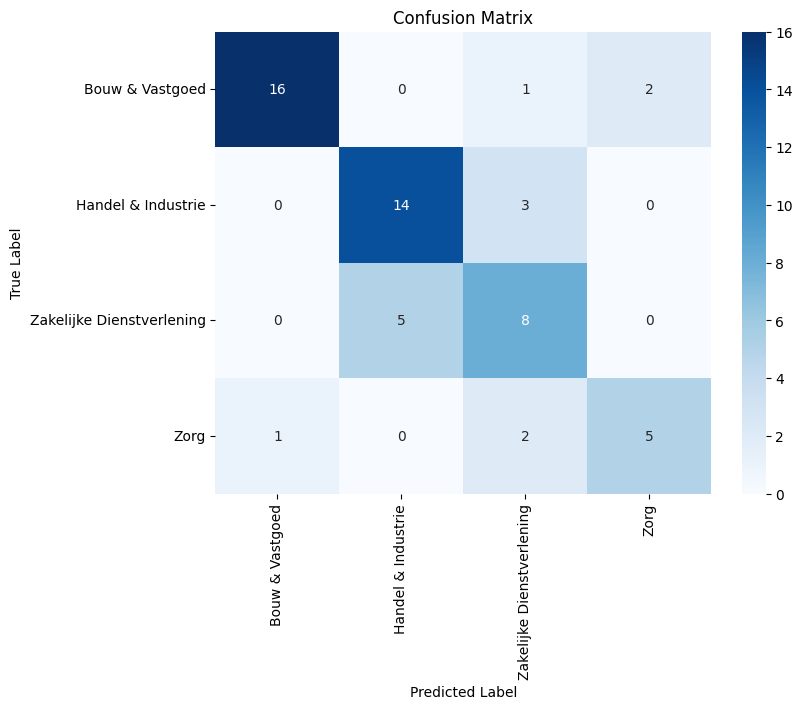

{2: {'accuracy': 0.6844598360003185, 'best_params': 1e-11},
 3: {'accuracy': 0.6906858340820605, 'best_params': 1e-11},
 5: {'accuracy': 0.694047619047619, 'best_params': 1e-07}}

In [57]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)

In [ ]:
# To Do:

# -Add some print statements to show the model chosen en parameters, especially for Gaussian- of Multinomial Naive Bayes
# -Print update of best model after every k
# -Clean Code and add/remove/update comments where needed
# -Return actual model and validation accuracy such that we can visualize the results in confusion matrices
# -If 2 classes too close in likelihood or no class likelihood exceeds threshold, then say class 5

# Finding the best model

Our goal is to find the classifier with the highest validation accuracy for each model type

In [58]:
# Ignore all warnings since they cause problems for te progress bars
warnings.simplefilter("ignore")

In [62]:
# Support Vector Machine

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="svm",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")
            
            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:26<12:57, 26.82s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666
Best validaton accuracy increased from -inf to 0.7291666666666666 with params BoW, none, (0.1, 'linear').

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▍                                                             | 2/30 [01:16<18:41, 40.06s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [01:52<17:13, 38.29s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [02:39<18:10, 41.94s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|███████████                                                       | 5/30 [03:23<17:41, 42.45s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|█████████████▏                                                    | 6/30 [03:52<15:11, 37.97s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|███████████████▍                                                  | 7/30 [04:43<16:07, 42.08s/iteration]

Maximum validation accuracy this iteration: 0.4791666666666667

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|█████████████████▌                                                | 8/30 [05:23<15:13, 41.51s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|███████████████████▊                                              | 9/30 [06:16<15:48, 45.17s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|█████████████████████▋                                           | 10/30 [07:05<15:23, 46.20s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|███████████████████████▊                                         | 11/30 [09:35<24:43, 78.10s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|█████████████████████████▌                                      | 12/30 [12:46<33:44, 112.49s/iteration]

Maximum validation accuracy this iteration: 0.5416666666666666

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|███████████████████████████▋                                    | 13/30 [15:20<35:23, 124.92s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|█████████████████████████████▊                                  | 14/30 [18:05<36:36, 137.27s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|████████████████████████████████                                | 15/30 [21:26<39:05, 156.34s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|██████████████████████████████████▏                             | 16/30 [23:52<35:45, 153.25s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|████████████████████████████████████▎                           | 17/30 [27:27<37:11, 171.69s/iteration]

Maximum validation accuracy this iteration: 0.5416666666666666

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|██████████████████████████████████████▍                         | 18/30 [30:35<35:19, 176.63s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|████████████████████████████████████████▌                       | 19/30 [33:52<33:31, 182.82s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|██████████████████████████████████████████▋                     | 20/30 [36:37<29:33, 177.36s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|████████████████████████████████████████████▊                   | 21/30 [38:40<24:10, 161.12s/iteration]

Maximum validation accuracy this iteration: 0.75
Best validaton accuracy increased from 0.7291666666666666 to 0.75 with params RobBERT, none, (0.1, 'linear').

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|██████████████████████████████████████████████▉                 | 22/30 [41:38<22:10, 166.32s/iteration]

Maximum validation accuracy this iteration: 0.5208333333333334

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|█████████████████████████████████████████████████               | 23/30 [44:15<19:03, 163.35s/iteration]

Maximum validation accuracy this iteration: 0.75

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|███████████████████████████████████████████████████▏            | 24/30 [47:00<16:24, 164.02s/iteration]

Maximum validation accuracy this iteration: 0.75

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|█████████████████████████████████████████████████████▎          | 25/30 [49:46<13:41, 164.39s/iteration]

Maximum validation accuracy this iteration: 0.75

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|███████████████████████████████████████████████████████▍        | 26/30 [49:50<07:45, 116.40s/iteration]

Maximum validation accuracy this iteration: 0.3958333333333333

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|██████████████████████████████████████████████████████████▌      | 27/30 [50:27<04:38, 92.70s/iteration]

Maximum validation accuracy this iteration: 0.4791666666666667

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|████████████████████████████████████████████████████████████▋    | 28/30 [50:52<02:24, 72.16s/iteration]

Maximum validation accuracy this iteration: 0.5

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|██████████████████████████████████████████████████████████████▊  | 29/30 [51:30<01:01, 61.89s/iteration]

Maximum validation accuracy this iteration: 0.4791666666666667

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|████████████████████████████████████████████████████████████████| 30/30 [52:05<00:00, 104.17s/iteration]

Maximum validation accuracy this iteration: 0.3958333333333333
Best overall model: ('RobBERT', 'none', 1)
Best overall accuracy: 0.75
Best overall parameters: (0.1, 'linear')


In [75]:
# Naive Bayes

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="naive_bayes",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:01<00:36,  1.27s/iteration]

Maximum validation accuracy this iteration: 0.7708333333333334
Best validaton accuracy increased from -inf to 0.7708333333333334 with params BoW, none, (0.01, True).

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▍                                                             | 2/30 [00:13<03:40,  7.88s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [00:26<04:26,  9.87s/iteration]

Maximum validation accuracy this iteration: 0.7708333333333334

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [00:39<04:53, 11.30s/iteration]

Maximum validation accuracy this iteration: 0.7708333333333334

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|███████████                                                       | 5/30 [00:53<05:03, 12.14s/iteration]

Maximum validation accuracy this iteration: 0.7291666666666666

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|█████████████▏                                                    | 6/30 [00:54<03:23,  8.46s/iteration]

Maximum validation accuracy this iteration: 0.7916666666666666
Best validaton accuracy increased from 0.7708333333333334 to 0.7916666666666666 with params tf-idf, none, (0.1, False).

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|███████████████▍                                                  | 7/30 [01:06<03:44,  9.76s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|█████████████████▌                                                | 8/30 [01:19<03:52, 10.55s/iteration]

Maximum validation accuracy this iteration: 0.6908730158730159

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|███████████████████▊                                              | 9/30 [01:32<04:01, 11.49s/iteration]

Maximum validation accuracy this iteration: 0.6875

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|█████████████████████▋                                           | 10/30 [01:46<04:04, 12.22s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|███████████████████████▊                                         | 11/30 [03:58<15:29, 48.90s/iteration]

Maximum validation accuracy this iteration: 0.6666666666666666

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|██████████████████████████                                       | 12/30 [06:12<22:24, 74.71s/iteration]

Maximum validation accuracy this iteration: 0.4583333333333333

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|████████████████████████████▏                                    | 13/30 [08:03<24:18, 85.80s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|██████████████████████████████▎                                  | 14/30 [09:53<24:50, 93.15s/iteration]

Maximum validation accuracy this iteration: 0.3958333333333333

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|████████████████████████████████▌                                | 15/30 [11:42<24:25, 97.70s/iteration]

Maximum validation accuracy this iteration: 0.29310515873015874

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|██████████████████████████████████▏                             | 16/30 [13:27<23:20, 100.05s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|████████████████████████████████████▎                           | 17/30 [15:17<22:20, 103.08s/iteration]

Maximum validation accuracy this iteration: 0.4583333333333333

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|██████████████████████████████████████▍                         | 18/30 [17:03<20:46, 103.86s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|████████████████████████████████████████▌                       | 19/30 [18:50<19:11, 104.72s/iteration]

Maximum validation accuracy this iteration: 0.3628691983122363

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|██████████████████████████████████████████▋                     | 20/30 [20:35<17:28, 104.83s/iteration]

Maximum validation accuracy this iteration: 0.2837301587301587

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|████████████████████████████████████████████▊                   | 21/30 [22:22<15:50, 105.64s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|██████████████████████████████████████████████▉                 | 22/30 [24:12<14:14, 106.82s/iteration]

Maximum validation accuracy this iteration: 0.4791666666666667

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|█████████████████████████████████████████████████               | 23/30 [26:01<12:32, 107.45s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|███████████████████████████████████████████████████▏            | 24/30 [27:51<10:49, 108.33s/iteration]

Maximum validation accuracy this iteration: 0.37875000000000003

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|█████████████████████████████████████████████████████▎          | 25/30 [29:40<09:03, 108.61s/iteration]

Maximum validation accuracy this iteration: 0.29002976190476193

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|████████████████████████████████████████████████████████▎        | 26/30 [29:41<05:04, 76.21s/iteration]

Maximum validation accuracy this iteration: 0.2774782869122492

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|██████████████████████████████████████████████████████████▌      | 27/30 [29:42<02:41, 53.68s/iteration]

Maximum validation accuracy this iteration: 0.4583333333333333

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|████████████████████████████████████████████████████████████▋    | 28/30 [29:43<01:15, 37.84s/iteration]

Maximum validation accuracy this iteration: 0.3221774193548387

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|██████████████████████████████████████████████████████████████▊  | 29/30 [29:45<00:26, 26.95s/iteration]

Maximum validation accuracy this iteration: 0.3439614680359844

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|█████████████████████████████████████████████████████████████████| 30/30 [29:46<00:00, 59.56s/iteration]

Maximum validation accuracy this iteration: 0.28055555555555556
Best overall model: ('tf-idf', 'none', 1)
Best overall accuracy: 0.7916666666666666
Best overall parameters: (0.1, False)


In [64]:
# Random Forest

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="random_forest",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██                                                             | 1/30 [06:20<3:03:41, 380.06s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334
Best validaton accuracy increased from -inf to 0.5833333333333334 with params BoW, none, 15.

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▏                                                          | 2/30 [12:22<2:52:25, 369.48s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▎                                                        | 3/30 [18:53<2:50:43, 379.39s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666
Best validaton accuracy increased from 0.5833333333333334 to 0.6041666666666666 with params BoW, ngram, 5.

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▍                                                      | 4/30 [27:05<3:03:37, 423.73s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|██████████▌                                                    | 5/30 [34:05<2:56:02, 422.49s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|████████████▌                                                  | 6/30 [39:22<2:34:39, 386.64s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|██████████████▋                                                | 7/30 [44:59<2:21:58, 370.39s/iteration]

Maximum validation accuracy this iteration: 0.625
Best validaton accuracy increased from 0.6041666666666666 to 0.625 with params tf-idf, one-hot, 10.

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|████████████████▊                                              | 8/30 [51:21<2:17:11, 374.15s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|██████████████████▉                                            | 9/30 [59:23<2:22:48, 408.01s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|████████████████████                                        | 10/30 [1:06:26<2:17:31, 412.55s/iteration]

Maximum validation accuracy this iteration: 0.5204166666666666

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|██████████████████████                                      | 11/30 [1:11:24<1:59:30, 377.38s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334
Best validaton accuracy increased from 0.625 to 0.6458333333333334 with params BERTje, none, 15.

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|████████████████████████                                    | 12/30 [1:18:00<1:54:54, 383.03s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|██████████████████████████                                  | 13/30 [1:24:28<1:49:00, 384.74s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|████████████████████████████                                | 14/30 [1:31:24<1:45:06, 394.17s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|██████████████████████████████                              | 15/30 [1:38:47<1:42:13, 408.89s/iteration]

Maximum validation accuracy this iteration: 0.6666666666666666
Best validaton accuracy increased from 0.6458333333333334 to 0.6666666666666666 with params BERTje, ngram, 15.

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|████████████████████████████████                            | 16/30 [1:44:31<1:30:47, 389.09s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|██████████████████████████████████                          | 17/30 [1:51:09<1:24:53, 391.82s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|████████████████████████████████████                        | 18/30 [1:57:42<1:18:26, 392.23s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|██████████████████████████████████████                      | 19/30 [2:04:36<1:13:07, 398.86s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|████████████████████████████████████████                    | 20/30 [2:11:37<1:07:34, 405.40s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|███████████████████████████████████████████▍                  | 21/30 [2:16:35<56:00, 373.35s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|█████████████████████████████████████████████▍                | 22/30 [2:23:12<50:43, 380.41s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|███████████████████████████████████████████████▌              | 23/30 [2:29:46<44:51, 384.43s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|█████████████████████████████████████████████████▌            | 24/30 [2:36:43<39:24, 394.05s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|███████████████████████████████████████████████████▋          | 25/30 [2:43:48<33:36, 403.36s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|█████████████████████████████████████████████████████▋        | 26/30 [2:46:10<21:40, 325.15s/iteration]

Maximum validation accuracy this iteration: 0.34500000000000003

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|███████████████████████████████████████████████████████▊      | 27/30 [2:49:26<14:18, 286.26s/iteration]

Maximum validation accuracy this iteration: 0.4038035339922132

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|█████████████████████████████████████████████████████████▊    | 28/30 [2:52:37<08:35, 257.84s/iteration]

Maximum validation accuracy this iteration: 0.441633064516129

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [2:56:13<04:05, 245.12s/iteration]

Maximum validation accuracy this iteration: 0.41949685534591197

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|██████████████████████████████████████████████████████████████| 30/30 [2:59:55<00:00, 359.83s/iteration]

Maximum validation accuracy this iteration: 0.37583333333333335
Best overall model: ('BERTje', 'ngram', 1)
Best overall accuracy: 0.6666666666666666
Best overall parameters: 15



Using TF-IDF Embeddings...
Best naive_bayes Params for k=1: (0.1, False), Mean Validation Accuracy: 0.7917
param_results: {(0.01, True): [0.7708333333333334], (0.01, False): [0.75], (0.1, True): [0.7708333333333334], (0.1, False): [0.7916666666666666], (0.5, True): [0.6875], (0.5, False): [0.7291666666666666], (1.0, True): [0.5625], (1.0, False): [0.6875], (2.0, True): [0.5625], (2.0, False): [0.6666666666666666], (5.0, True): [0.5625], (5.0, False): [0.6041666666666666], (10.0, True): [0.5416666666666666], (10.0, False): [0.5833333333333334]}
mean results: {(0.01, True): 0.7708333333333334, (0.01, False): 0.75, (0.1, True): 0.7708333333333334, (0.1, False): 0.7916666666666666, (0.5, True): 0.6875, (0.5, False): 0.7291666666666666, (1.0, True): 0.5625, (1.0, False): 0.6875, (2.0, True): 0.5625, (2.0, False): 0.6666666666666666, (5.0, True): 0.5625, (5.0, False): 0.6041666666666666, (10.0, True): 0.5416666666666666, (10.0, False): 0.5833333333333334}
best validation accuracy for K=1: 0

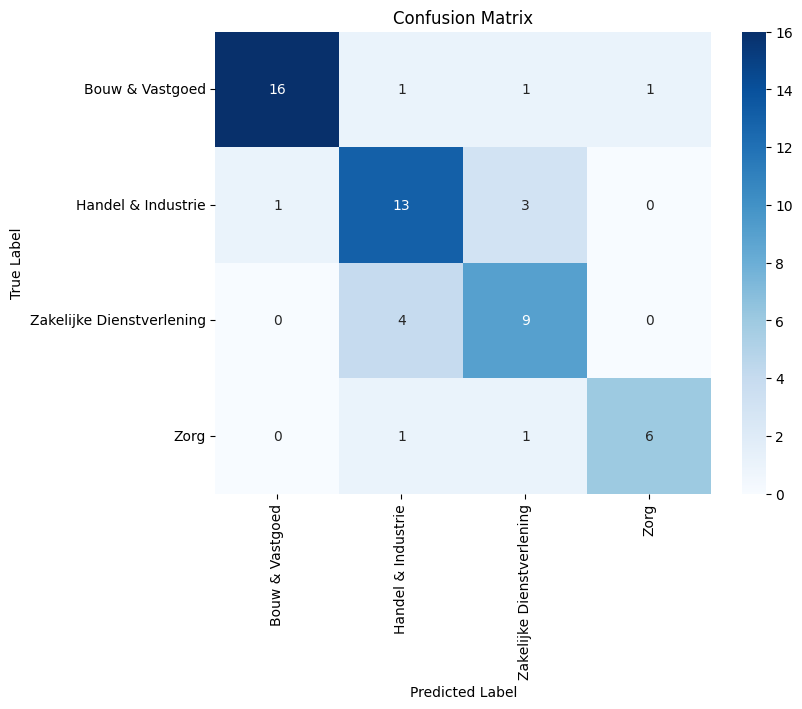

In [138]:
# Model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="tf-idf", 
                               model_type="naive_bayes",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]

# Small test on 2 articles

This section aims to test the obtained classifier for 2 articles. To achieve this, we first load the data

In [139]:
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

directory = 'small experiment for presentation'
df_experiment = pd.DataFrame(columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])

print('Please ensure that only pdf files of articles are present in the subfolders of the specified directory')
article_nr = 1
for folder in os.listdir(directory):
    folder_size = len(os.listdir(directory + "\\" + folder))
    print(f'{folder_size} article(s) detected in {folder} folder')
    
    for article in os.listdir(directory + '\\' + folder):
        text = extract_text_from_pdf(directory + '\\' + folder + '\\' + article)
        date = article.split(' ')[-1].split('.')[0] #Remove the article number and ".pdf" to obtain the publication date
        
        paragraphs = [para.strip() for para in text.split("\n \n") if para.strip()]
        para_nr = 1
        for para in paragraphs:
            df_temp = pd.DataFrame([[article_nr, para_nr, para, folder, date]], 
                                   columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])
            df_experiment = pd.concat([df_experiment, df_temp])
            para_nr += 1
        article_nr += 1
        
df_experiment.set_index(['article_id' , 'paragraph_id'], inplace=True)
df_experiment['publication_date'] = pd.to_datetime(df_experiment['publication_date'], format='%d-%m-%Y')

Please ensure that only pdf files of articles are present in the subfolders of the specified directory
1 article(s) detected in Bouw & Vastgoed folder
0 article(s) detected in Handel & Industrie folder
1 article(s) detected in Zakelijke Dienstverlening folder
0 article(s) detected in Zorg folder


In [140]:
df_experiment

text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Accountants Deloitte overtraden beroepsregels ...   
           2             ‘Passende maatregelen’ \n‘Ons interne onderzoe...   
           3             Scholen vinden lastig een accountant \nDe onde...   

                                             group publication_date  
article_id paragraph_id                                              
1          1                       Bouw & Vastgoed       2024-12-23  
           2                       Bouw & Vastgoed       2024-12-23  
           3                       Bouw & Vastgoed       2024-12-23  
           4                       Bouw & Vastgoed       2024-12-23  
2          1             Zakelijke Dienstverlening       2025-01-06  
           2             Zakelijke Dienstverlening       2025-01-06  
           3             Zakelijke Dienstverlening       2025-01-06

In [141]:
# Load the 'nl_core_news_sm' model
nlp = spacy.load('nl_core_news_sm')

# Add [NEWLINE] as a single token so that it is not split into 3 seperate tokens
special_cases = {"[NEWLINE]": [{"ORTH": "[NEWLINE]"}]}
nlp.tokenizer.add_special_case("[NEWLINE]", [{"ORTH": "[NEWLINE]"}])

df_experiment_clean = df_experiment.copy()
df_experiment_clean['original_text'] = df_experiment_clean['text'].copy()
df_experiment_clean = df_experiment_clean[['original_text', 'text', 'group']]

In [142]:
def case_normalization(text):
    """Returns string of input containing only lowercase letters apart from [NEWLINE], which replaces \n"""
    text = text.lower()
    text = text.replace('\n', ' [NEWLINE] ')
    while text != text.replace('  ', ' '):
        text = text.replace('  ', ' ')
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(case_normalization)

In [143]:
def remove_punctuation(text):
    """Returns the input text with all punctuation removed"""
    
    text = text.translate(text.maketrans("", "", string.punctuation))
    text = text.replace("NEWLINE", "[NEWLINE]")
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_punctuation)

In [144]:
def remove_stopwords(text):
    """Returns string of input text with stopwords removed"""
    
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    text = " ".join(filtered_words)
    return text
    
    
# nlp = spacy.load("nl_core_news_sm")
df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_stopwords)

In [145]:
def lemmatization(df, text_column="text", output_column="text"):
    """Lemmatizes the text in a specified column of a DataFrame and adds the results to a new column."""
    
    # Ensure the input column exists in the DataFrame
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' does not exist in the DataFrame.")
        
    # Apply SpaCy processing and lemmatization
    df[output_column] = df[text_column].apply(
        lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_space]))
    
    return df

df_experiment_clean['text before lemmatization'] = df_experiment_clean['text'].copy()
df_experiment_clean = lemmatization(df_experiment_clean, text_column="text")

In [146]:
def POS_tagging(text):
    """Returns a list of (token, POS tag) tuples for the input text"""
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

df_experiment_clean['pos_tags'] = df_experiment_clean['text'].apply(POS_tagging)

In [147]:
df_experiment_clean

original_text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Accountants Deloitte overtraden beroepsregels ...   
           2             ‘Passende maatregelen’ \n‘Ons interne onderzoe...   
           3             Scholen vinden lastig een accountant \nDe onde...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             huis 12 duur november groot stijging ruim twee...   
           2             jarenlange daling huizenprijzen beginnen 2013 ...   
           3             november wisselden 17973 woning eigenaar 18 tr...   
           4             corrigeren inflatie huizenprijzen Nederland 20...   
2          1             accountant deloiten overtraen beroepsregel ond...   
           2             passen maatregel [NEWLINE] intern onderzoek af...   
           3             school vinden lastig accountant [NEWLINE] onde...   

                                             group  \
article_id paragraph_id                              
1          1                       Bouw & Vastgoed   
           2                       Bouw & Vastgoed   
           3                       Bouw & Vastgoed   
           4                       Bouw & Vastgoed   
2          1             Zakelijke Dienstverlening   
           2             Zakelijke Dienstverlening   
           3             Zakelijke Dienstverlening   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             huizen 12 duurder november grootste stijging r...   
           2             jarenlange dalingen huizenprijzen begonnen 201...   
           3             november wisselden 17973 woningen eigenaar 18 ...   
           4             gecorrigeerd inflatie huizenprijzen nederland ...   
2          1             accountants deloitte overtraden beroepsregels ...   
           2             ‘ passende maatregelen ’ [NEWLINE] ‘ interne o...   
           3             scholen vinden lastig accountant [NEWLINE] ond...   

                                                                  pos_tags  
article_id paragraph_id                                                     
1          1             [(huis, NOUN), (12, NUM), (duur, NOUN), (novem...  
           2             [(jarenlange, ADJ), (daling, NOUN), (huizenpri...  
           3             [(november, PROPN), (wisselden, VERB), (17973,...  
           4             [(corrigeren, ADJ), (inflatie, NOUN), (huizenp...  
2          1             [(accountant, NOUN), (deloiten, VERB), (overtr...  
           2             [(passen, VERB), (maatregel, NOUN), ([NEWLINE]...  
           3             [(school, NOUN), (vinden, VERB), (lastig, ADJ)...

In [148]:
# Now we feed the data to the best model we found

df["label"] = df["group"].astype("category").cat.codes 
df_experiment_clean["label"] = df_experiment_clean["group"].astype("category").cat.codes 
df_train, df_test = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)

# Though we do not need to retrain the model, we do need to fit_transform it using tf-idf so that we can transform X_test the same way.
vectorizer = TfidfVectorizer(max_features=10_000)
X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_experiment_clean["text"])
y_test = df_experiment_clean["label"]

y_pred = final_nb.predict(X_test)
test_accuracy = accuracy_score(y_test, final_nb.predict(X_test))
test_accuracy

0.42857142857142855

In [149]:
y_pred

array([0, 0, 0, 1, 2, 2, 2], dtype=int8)

We can see that the classifier performs quite well for the first article (75% accurate). For the 2nd article however, all paragraphs have been classified incorrectly.

# Adding class 5 (uncertain class) to the classifier

Firstly, we start by visualizing the following 2 aspects of our resulting classifier: <br>
> - The maximum predicted probability amongs the 4 classes for each individual instance
> - The difference in predicted probability between the most and second most likely class for each individual instance.

In [150]:
X_train_final_model, y_train_final_model = data_final_model[0][0], data_final_model[0][1]
X_val_final_model, y_val_final_model = data_final_model[1][0], data_final_model[1][1]
X_test_final_model, y_test_final_model = data_final_model[2][0], data_final_model[2][1]

y_pred_test = final_nb.predict(X_test_final_model)
y_pred_test_proba = final_nb.predict_proba(X_test_final_model)
y_pred_test_proba_max = [max(probs) for probs in y_pred_test_proba]
y_pred_test_proba_diff = [sorted(probs, reverse=True)[0] - sorted(probs, reverse=True)[1] for probs in y_pred_test_proba]

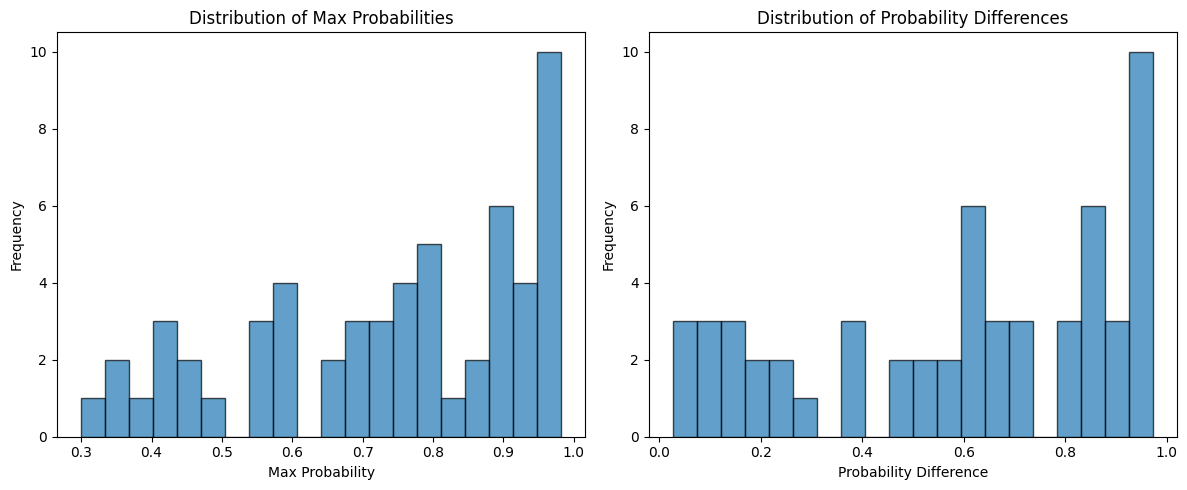

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First histogram (Max Probability)
axes[0].hist(y_pred_test_proba_max, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Max Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Max Probabilities')

# Second histogram (Difference between Top 2 Probabilities)
axes[1].hist(y_pred_test_proba_diff, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Probability Difference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Probability Differences')

# Adjust layout
plt.tight_layout()
plt.show()

Now we add the functionality to predict the 5th class, the uncentain class

In [152]:
def predict_including_unknown(classifier, X, threshold=0.5, margin=0.2):
    """
    Predicts class labels for X, with an additional 'Unknown' class if:
    1. No class probability exceeds the threshold.
    2. The highest probability is not at least (1 + margin) times the second highest.
    
    :param classifier: A trained Naïve Bayes classifier with predict_proba().
    :param X: Input features.
    :param threshold: Minimum probability a class must exceed.
    :param margin: Minimum percentage difference between the top 2 classes.
    :return: Array of predicted labels, with 'Unknown' for uncertain predictions.
    """
    probas = classifier.predict_proba(X)  # Get probability estimates
    classes = classifier.classes_  # Get class labels
    predictions = []

    for probs in probas:
        max_prob = np.max(probs)
        sorted_probs = np.sort(probs)[::-1]  # Sort in descending order
        second_max_prob = sorted_probs[1] if len(sorted_probs) > 1 else 0

        # Check for uncertainty conditions
        if max_prob < threshold or max_prob < (1 + margin) * second_max_prob:
            predictions.append(5)
        else:
            predictions.append(classes[np.argmax(probs)])

    return np.array(predictions)

In [153]:
def filtered_accuracy(classifier, X_test, y_test, threshold=0.4, margin=0.2):
    """
    Computes accuracy on instances where a reliable prediction is made.

    :param classifier: A trained Naïve Bayes classifier with predict_proba().
    :param X_test: Test feature matrix.
    :param y_test: True labels for X_test.
    :param threshold: Minimum probability a class must exceed.
    :param margin: Minimum percentage difference between the top 2 classes.
    :return: Accuracy computed only on reliable predictions.
    """
    y_pred = predict_including_unknown(classifier, X_test, threshold, margin)
    
    # Filter out "Unknown" predictions
    mask = y_pred != 5
    filtered_y_pred = y_pred[mask]
    filtered_y_test = y_test[mask]
    
    # Compute accuracy only on valid predictions
    if len(filtered_y_test) == 0:
        return None  # Avoid division by zero, no reliable predictions made

    accuracy = np.mean(filtered_y_pred == filtered_y_test)
    return accuracy

In [154]:
thresholds = [0.2, 0.3, 0.4]
margins = [0.1, 0.15, 0.2]

for threshold in thresholds:
    for margin in margins:
        y_pred_incl_unknown = predict_including_unknown(final_nb, X_test_final_model, threshold=threshold, margin=margin)
        unknown_count = sum(1 for x in y_pred_incl_unknown if x == 5)
        unknown_rate = unknown_count / len(y_pred_incl_unknown)
        accuracy = filtered_accuracy(final_nb, X_test_final_model, y_test_final_model, threshold=threshold, margin=margin)
        print(f"Threshold={threshold}, Margin={margin}: {unknown_rate * 100:.2f}% unknown & {accuracy * 100:.2f}% accurate")

Threshold=0.2, Margin=0.1: 1.75% unknown & 76.79% accurate
Threshold=0.2, Margin=0.15: 3.51% unknown & 76.36% accurate
Threshold=0.2, Margin=0.2: 3.51% unknown & 76.36% accurate
Threshold=0.3, Margin=0.1: 1.75% unknown & 76.79% accurate
Threshold=0.3, Margin=0.15: 3.51% unknown & 76.36% accurate
Threshold=0.3, Margin=0.2: 3.51% unknown & 76.36% accurate
Threshold=0.4, Margin=0.1: 7.02% unknown & 75.47% accurate
Threshold=0.4, Margin=0.15: 7.02% unknown & 75.47% accurate
Threshold=0.4, Margin=0.2: 7.02% unknown & 75.47% accurate


# Testing for duplicate data

In [155]:
article_texts = df.groupby("article_id")["text"].apply(lambda x: " ".join(x)).reset_index()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert article texts into a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(article_texts["text"])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Convert to DataFrame for better readability
cosine_df = pd.DataFrame(cosine_sim, index=article_texts["article_id"], columns=article_texts["article_id"])

# Find pairs with similarity > 0.99 (excluding self-similarity)
similar_articles = []
threshold = 0.99

for i, id1 in enumerate(article_texts["article_id"]):
    for j, id2 in enumerate(article_texts["article_id"]):
        if i < j and cosine_df.loc[id1, id2] > threshold:
            similar_articles.append((id1, id2, cosine_df.loc[id1, id2]))

# Display results
similar_articles_df = pd.DataFrame(similar_articles, columns=["article_1", "article_2", "similarity"])
print(similar_articles_df)

    article_1  article_2  similarity
0           7         39    1.000000
1          13        107    1.000000
2          19         53    1.000000
3          19         90    1.000000
4          19        109    1.000000
5          24         62    0.996245
6          24         99    0.995303
7          24        117    0.995303
8          25         72    0.999984
9          33        103    0.991317
10         44         81    1.000000
11         47         85    1.000000
12         51         89    0.998005
13         53         90    1.000000
14         53        109    1.000000
15         54         94    1.000000
16         62         99    0.999947
17         62        117    0.999947
18         90        109    1.000000
19         99        117    1.000000


In [163]:
# Aggregate text and file_path for each article_id
article_info = df.groupby("article_id").agg(
    text=("text", lambda x: " ".join(x)),
    file_path=("file_path", "first")  # Assuming each article has a unique file_path
).reset_index()

# Compute the TF-IDF matrix and cosine similarity as before
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(article_info["text"])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Convert to DataFrame for better readability
cosine_df = pd.DataFrame(cosine_sim, index=article_info["article_id"], columns=article_info["article_id"])

# Find pairs with similarity > 0.99 (excluding self-similarity)
similar_articles = []
threshold = 0.99

for i, id1 in enumerate(article_info["article_id"]):
    for j, id2 in enumerate(article_info["article_id"]):
        if i < j and cosine_df.loc[id1, id2] > threshold:
            similar_articles.append((
                id1, 
                id2, 
                article_info.loc[article_info["article_id"] == id1, "file_path"].values[0],  # File path for article 1
                article_info.loc[article_info["article_id"] == id2, "file_path"].values[0],   # File path for article 2
                cosine_df.loc[id1, id2]
            ))

# Display results with file paths
similar_articles_df = pd.DataFrame(similar_articles, columns=["article_1", "article_2", "file_path_1", "file_path_2", "similarity"])
similar_articles_df

,article_1,article_2,file_path_1,file_path_2,similarity
0,7,39,"data\Bouw & Vastgoed\15, 29-10-2024.pdf","data\Handel & Industrie\20, 29-10-2024.pdf",1.000000
1,13,107,"data\Bouw & Vastgoed\20, 19-11-2024.pdf","data\Zorg\15, 19-11-2024.pdf",1.000000
2,19,53,"data\Bouw & Vastgoed\26, 04-12-2024.pdf","data\Handel & Industrie\33, 04-12-2024.pdf",1.000000
3,19,90,"data\Bouw & Vastgoed\26, 04-12-2024.pdf","data\Zakelijke Dienstverlening\33, 04-12-2024.pdf",1.000000
4,19,109,"data\Bouw & Vastgoed\26, 04-12-2024.pdf","data\Zorg\17, 04-12-2024.pdf",1.000000
5,24,62,"data\Bouw & Vastgoed\7, 01-10-2024.pdf","data\Handel & Industrie\8, 01-10-2024.pdf",0.996245
6,24,99,"data\Bouw & Vastgoed\7, 01-10-2024.pdf","data\Zakelijke Dienstverlening\8, 01-10-2024.pdf",0.995303
7,24,117,"data\Bouw & Vastgoed\7, 01-10-2024.pdf","data\Zorg\6, 01-10-2024.pdf",0.995303
8,25,72,"data\Bouw & Vastgoed\8, 22-10-2024.pdf","data\Zakelijke Dienstverlening\17, 22-10-2024.pdf",0.999984
9,33,103,"data\Handel & Industrie\15, 21-10-2024.pdf","data\Zorg\11, 21-10-2024.pdf",0.991317


The following choices were made: <br>
> - Row 0: Handel & Industrie 
> - Row 1: Zakelijke Dienstverlening 
> - Row 2-4 + 13-14 + 18: Zakelijke Dienstverlening 
> - Row 5-7 + 16-17 + 19: Zakelijke Dienstverlening 
> - Row 8: Bouw & vastgoed
> - Row 9: Zorg
> - Row 10: Handel & Industrie
> - Row 11: Handel & Industrie
> - Row 12: Zakelijke Dienstverlening
> - Row 15: Handel & Industrie